In [1]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


from keras import backend as K
K.image_data_format()
#K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'chest_xray/train/'
validation_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

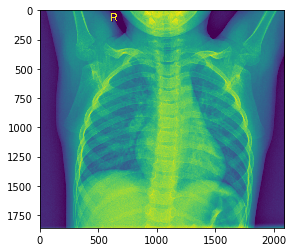

In [4]:
img = mpimg.imread(train_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

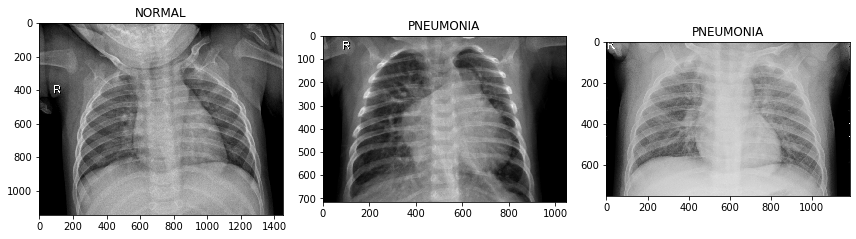

In [5]:
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [6]:
K.clear_session()

NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()



87916544/87910968 [==============================] - ETA: 15:2 - ETA: 6:3 - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 58 - ETA: 57 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - E

batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 72, 72, 32)   9216        activation_1[0][0]               
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 72, 72, 32)   96          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 72, 72, 32)   0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_3 (

__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 16, 16, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 16, 16, 64)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 16, 16, 48)   12288       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 96)   55296       activation_16[0][0]              
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 16, 16, 48)   144         conv2d_14[0][0]                  
__________

batch_normalization_26 (BatchNo (None, 16, 16, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 16, 16, 64)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 16, 16, 64)   0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 16, 16, 96)   0           batch_normalization_25[0][0]     
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 16, 16, 64)   0           batch_normalization_26[0][0]     
__________________________________________________________________________________________________
mixed2 (Co

__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 7, 7, 192)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 7, 7, 192)    172032      activation_33[0][0]              
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 7, 7, 192)    172032      activation_38[0][0]              
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 7, 7, 192)    147456      average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 7, 7, 192)    576         conv2d_31[0][0]                  
__________

batch_normalization_50 (BatchNo (None, 7, 7, 192)    576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 7, 7, 192)    0           batch_normalization_41[0][0]     
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 7, 7, 192)    0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 7, 7, 192)    0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 7, 7, 192)    0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
mixed5 (Co

conv2d_65 (Conv2D)              (None, 7, 7, 192)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 7, 7, 192)    576         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 7, 7, 192)    0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 7, 7, 192)    258048      activation_65[0][0]              
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 7, 7, 192)    576         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 7, 7, 192)    576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 7, 7, 192)    576         conv2d_75[0][0]                  
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 7, 7, 192)    0           batch_normalization_71[0][0]     
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 7, 7, 192)    0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 3, 3, 320)    552960      activation_71[0][0]              
__________

                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3, 3, 768)    0           activation_83[0][0]              
                                                                 activation_84[0][0]              
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 3, 3, 192)    0           batch_normalization_85[0][0]     
__________________________________________________________________________________________________
mixed9 (Concatenate)            (None, 3, 3, 2048)   0           activation_77[0][0]              
                                                                 mixed9_0[0][0]                   
                                                                 concatenate_1[0][0]              
          

__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dropout_2[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 128)          0           dense_3[0][0]                    
__________

In [7]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(2048, 512) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_4/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32>]

In [8]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [9]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
from sklearn.utils.class_weight import compute_class_weight

y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


In [14]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=1,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Epoch 1/1
32/32 [==============================] - ETA: 13:34 - loss: 0.3974 - accuracy: 0.852 - ETA: 9:45 - loss: 0.3564 - accuracy: 0.843 - ETA: 8:22 - loss: 0.3629 - accuracy: 0.84 - ETA: 7:31 - loss: 0.3473 - accuracy: 0.84 - ETA: 6:57 - loss: 0.3285 - accuracy: 0.85 - ETA: 6:27 - loss: 0.3320 - accuracy: 0.85 - ETA: 6:03 - loss: 0.3287 - accuracy: 0.86 - ETA: 5:42 - loss: 0.3161 - accuracy: 0.87 - ETA: 5:24 - loss: 0.3093 - accuracy: 0.87 - ETA: 5:06 - loss: 0.3095 - accuracy: 0.87 - ETA: 4:49 - loss: 0.3077 - accuracy: 0.87 - ETA: 4:34 - loss: 0.3072 - accuracy: 0.87 - ETA: 4:18 - loss: 0.3061 - accuracy: 0.87 - ETA: 4:03 - loss: 0.3098 - accuracy: 0.88 - ETA: 3:47 - loss: 0.3058 - accuracy: 0.88 - ETA: 3:33 - loss: 0.3020 - accuracy: 0.88 - ETA: 3:20 - loss: 0.3005 - accuracy: 0.88 - ETA: 3:06 - loss: 0.3011 - accuracy: 0.88 - ETA: 2:52 - loss: 0.3009 - accuracy: 0.88 - ETA: 2:38 - loss: 0.3009 - accuracy: 0.88 - ETA: 2:25 - loss: 0.3067 - accuracy: 0.87 - ETA: 2:11 - loss: 0.30

In [17]:
model = tf.keras.models.load_model(MODEL_FILE)

In [18]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

1/1 [==============================] - 26s 26s/step - loss: 1.3080 - acc: 0.6955


In [19]:
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

Loss     : 1.31  
Accuracy : 69.55%


In [55]:
test_generator.reset()
filenames = test_generator.filenames
#nb_samples = len(filenames)/100

predict = model.predict_generator(test_generator)

In [56]:
len(predict)

624

In [60]:
import pandas as pd

predicted_class_indices = np.argmax(predict, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [61]:
print(len(predictions), len(filenames))

624 624


In [63]:
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

results

,Filename,Predictions
0,NORMAL\IM-0001-0001.jpeg,PNEUMONIA
1,NORMAL\IM-0003-0001.jpeg,PNEUMONIA
2,NORMAL\IM-0005-0001.jpeg,PNEUMONIA
3,NORMAL\IM-0006-0001.jpeg,PNEUMONIA
4,NORMAL\IM-0007-0001.jpeg,PNEUMONIA
5,NORMAL\IM-0009-0001.jpeg,NORMAL
6,NORMAL\IM-0010-0001.jpeg,NORMAL
7,NORMAL\IM-0011-0001-0001.jpeg,PNEUMONIA
8,NORMAL\IM-0011-0001-0002.jpeg,PNEUMONIA
9,NORMAL\IM-0011-0001.jpeg,NORMAL
